<a href="https://colab.research.google.com/github/Tunia7/Model-populacji/blob/main/populacja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import random
import scipy
import math
from scipy.spatial import distance
from statistics import mean
import math
from copy import copy, deepcopy
from matplotlib import animation

In [ ]:
class Individual:
  def __init__(self, genome):
      self.genotype = genome
      self.fitness = 1 #?? 

  # zwraca fitness poszczególnego organizmu
  def fitness_calc(self, optimal_genotype, selection_variable):
    self.fitness = math.exp(-(distance.euclidean(self.genotype,optimal_genotype))/(2*selection_variable**2))
  
  # ?czemu taka metoda wyboru 
  def will_it_survive(self):
      will_it_happen = np.random.uniform(0,1)
      return will_it_happen <= self.fitness

In [ ]:
class History:
  def __init__(self, n_steps):
      self.n_of_inds = []
      self.last_step = n_steps
      self.optimal_genomes_changes = []
      self.time_of_catastrophe = 0
      self.number_of_descendants_changes = []
      self.mutations = []
      self.all_genomes = []


  # mutatated is dict with place in genome as key and list of changes as values
  def recording_mutations(self, mutated):
      self.mutations.append(mutated)

  def recording_optimum(self, optimal_genome):
      self.optimal_genomes_changes.append(optimal_genome)

  # descendants are dict with genome as key and list of numebr of kids as values
  def recording_descendants(self, descendants):
      self.number_of_descendants_changes.append(descendants)

  def recording_n(self, n):
    self.n_of_inds.append(n)
  
  def recordings_genes(self, genomes):
    self.all_genomes.append(genomes)

  # lista optymalnych wartości genu x
  def gene_x_optimum(self, x):
    return list(filter(None, [g[x - 1] for g in self.optimal_genomes_changes]))

  # lista wartości x-owego genu w poszczególnych iteracjach
  def genes_x(self, x):
    L = [[g.genotype for g in gs] for gs in self.all_genomes]
    return list(filter(None, [[g[x] for g in gs] for gs in L]))


 
  def plot_gen_changes(self):

    def subplot(x, col, a):
        mean_gene = [mean(g) for g in (self.genes_x(x-1))]  # lista średnich wartości genów w iteracjach
        n = [i for i in range(len(mean_gene))]  # liczba interacji
        gene_std = [np.std(g, ddof=1) for g in (self.genes_x(x-1))][0:len(mean_gene)]  # lista std dla każdej iteracji
        

        print(len(mean_gene))
        print(len(gene_std))
        print(len(n))

        a[x - 1].plot(n, mean_gene, color=col, label='mean')
        a[x - 1].fill_between(n, np.array(mean_gene) + np.array(gene_std), np.array(mean_gene) - np.array(gene_std), facecolor=col, alpha=0.5,
                              label='standard deviation')
        a[x - 1].plot(n, self.gene_x_optimum(x)[:len(n)], color='red', label='optimal gene value')
        a[x - 1].set_title('Gen %d' % x, fontsize='small', loc='left')
        a[x - 1].legend(loc='upper right', prop={'size': 6})

    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Changes in values of genes')

    subplot(1, "green", axs)
    subplot(2, "blue", axs)
    #subplot(3, "purple", axs)

    
    fig.supxlabel('Interation')
    fig.supylabel('Average Gen Value')
    plt.show()

  # ile potomstwa miały osobniki z danymi mutacjami w danych genach 
  def kids_from_mutation_plot():
    pass



In [ ]:
class Population:
    def __init__(self, N: int, l: int, p: float, var:float, optimal_genotype, selection_variable: float, rate: float, catastrophic_scenario):
        self.N = N  # number of individuals in the population
        self.l = l # the lenght of genome
        self.p = p  # probability of mutation
        self.var = var # rhe variance for normal distribution that decribes mutation streangth
        self.set_of_individuals = [Individual([0 for _ in range(0,l)]) for _ in range(0,N)]
        for ind in self.set_of_individuals:
          self.mutation(ind)
        self.optimal_genotype = optimal_genotype
        self.selection_variable = selection_variable
        self.rate = rate
        self.catastrophic_scenario = catastrophic_scenario


    def mutation(self, animal:  Individual):
      will_it_happen = np.random.uniform(0,1)
      how_much_is_changed = None
      to_change = None
      if will_it_happen < self.p:
        to_change = random.randint(0, len(animal.genotype)-1)    
        how_much_is_changed = np.random.normal(0,self.var)
        animal.genotype[to_change]+= how_much_is_changed
      return to_change, how_much_is_changed



    # ! zmiany losować z rozkłau normalnego
    def change(self):
      g = random.randint(0,len(self.optimal_genotype)-1)
      self.optimal_genotype[g] += np.random.normal(0, self.rate)
      return self.optimal_genotype

    # to do
    def catastrophe(self):
      for g in range(0, self.l):
        self.optimal_genotype[g] += 5*math.sqrt(self.rate)


    def simulation(self, n_generations: int, history =None):
      if history is None:
        history = History(n_generations)
        history.recordings_genes(self.set_of_individuals)
      history.recording_optimum(self.optimal_genotype)
      history.recording_descendants({})
      history.recording_mutations({i:[] for i in range(0, self.l)})
      history.recording_n(len(self.set_of_individuals))
      for n in range(0,n_generations):
        
        new_list_of_inds = []
        survived = [] # te które przeżyły w danej iteracji
        mutations = {i:[] for i in range(0, self.l)}

        for ind in self.set_of_individuals:

          # mutacja genomu
          to_change, how_much_is_changed = self.mutation(ind)
          if to_change is not None:
            mutations[to_change].append(how_much_is_changed)
          ind.fitness_calc(self.optimal_genotype,self.selection_variable)
          if ind.will_it_survive() == True:
            survived.append(ind)

        # rozmanażanie
        descendants = {}
        if len(survived) > 0:
          number_of_kids = sorted(np.random.poisson(lam =1.5, size = len(survived)))
          survived = sorted(survived, key = lambda x: x.fitness)
          for i in range(0, len(survived)):
            if number_of_kids[i]>0:
              if tuple(survived[i].genotype) in descendants.keys():
                descendants[tuple(survived[i].genotype)].append(number_of_kids[i])
              else:
                 descendants[tuple(survived[i].genotype)]=[number_of_kids[i]]
              for t in range(0,number_of_kids[i]):
                new_list_of_inds.append(survived[i])

        # wymieranie jeśli przekroczymy pojemność środowiska
        self.set_of_individuals = random.sample(new_list_of_inds, min(self.N*2, len(new_list_of_inds)))
        # !zapis danych nowej populacji nowej populacji
        history.recording_n(len(self.set_of_individuals))
        history.recordings_genes(self.set_of_individuals)
        a = deepcopy(self.change()) # zmiana genotypu optymalnego
        history.recording_optimum(a)
        if self.catastrophic_scenario == True and n>50:
            self.catastrophic_scenario = False
            pop2=deepcopy(self)
            history_w_c = deepcopy(history)
            self.catastrophe()
            history.time_of_catastrophe = n
        
        history.recording_descendants(descendants)
        history.recording_mutations(mutations)
      if history.time_of_catastrophe != 0:
        return history, pop2.simulation(n_generations - history.time_of_catastrophe, history_w_c)
      return history

  
    

# Paramatry testowe


In [ ]:
N = 1000 #ile osobników
l = 2 # ile cech ma genom
p = 0.075 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = 0.50
rate = 0.001
catastrophic_scenario = False

In [ ]:
# tworzymy k osobników z losowymi cechami i parametry populacji
pop_1 = Population(N, l, p, var, optimal_genotype, selection_variable, rate, catastrophic_scenario)
n_of_generations = 100  

In [ ]:
#test
records = pop_1.simulation(n_of_generations)

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


58
58
58
58
58
58


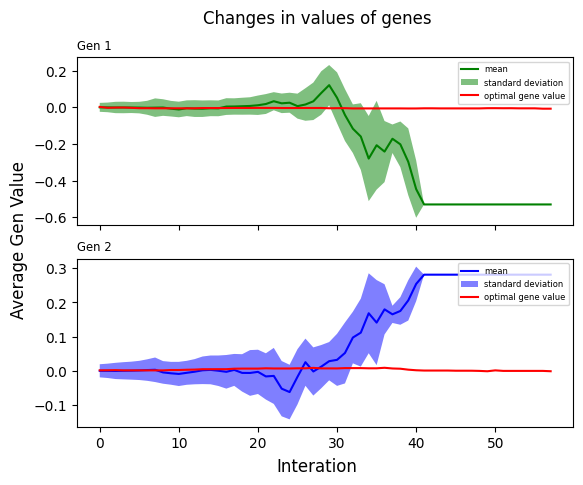

In [ ]:
records.plot_gen_changes()

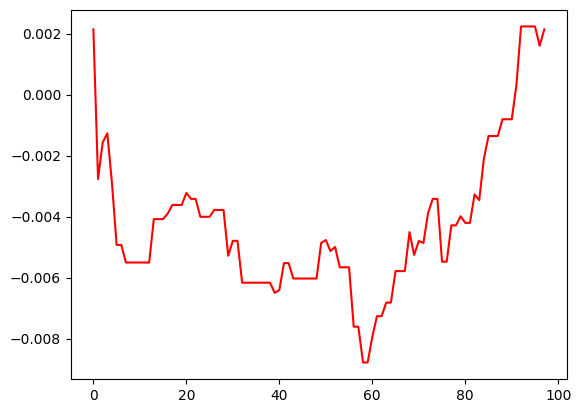

In [ ]:
plt.plot(records.gene_x_optimum(1), color='red', label='optimal gene value')

In [ ]:
print(records.number_of_descendants_changes)

[{}, {(0, 0): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [ ]:
print(records.mutations)

[{0: [], 1: []}, {0: [-0.008701846970732762, 0.006474958818572577, -0.008759213063165275, 0.0010727334077942584, -0.001894096751039897, 0.01771560004585717, 0.008791659951397161, 0.008863269194657086, -0.015462248902972207, 0.0010239505421082225, 0.0022890492846780624, 0.006802401296166751, 0.0015120934610982487, 0.0062425369270476625, -0.012566704572336993, 0.0061997062020134565, -0.0076456276588339304, 0.013611974034049573, -0.015960231683819534, -0.011788706443850388, -0.025554514181308434, -0.013022135535684862, 0.005405613740967941, 0.015535503549127484, -0.014156641522868286, 0.004471606324896147, 0.0010704768599173165, 0.025426585447971488, 0.013835872644171073, 0.0037851826454954603, 0.011720806462810603, 0.006703130751870457, -0.004643207023918468, -0.01048984519939855, 0.020630792172099805, 0.0019961933511635386, -0.010518056775756731, 0.021738558102359928, -0.01121370145602178, -0.0015584268544233824, -0.0016185584474408385, -0.0034882384308833193, -0.0013315065330946944, 0.

In [ ]:
P = records.all_genomes
L = [[g.genotype for g in gs] for gs in P]
print(L)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(records.genes_x(0))


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.009334703696691673, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0162022084452648, 0.0036265925131695916, 0, 0, 0, 0, 0, -0.008701846970732762, 0, 0, 0, 0, -0.02952778025227745, 0, 0, 0, 0, 0, 0, 0, 0, 0.007060945259861081, 0.009205908948716797, 0, 0, 0.023861736578838635, 0, 0.023312400376304224, 0, 0.009600709054330475, 0, 0, 0.009765494406614991, 0.0022730017211692313, 0, 0, 0, 0.03189136236100793, -0.00591229098608895, 0.02058135294380282, -0.015735485628170894, -0.005583702448606358, 0.019139459016883013, 0.0033105056118604517, -0.0027010007487522194, -0.05306110035222778, 0.047268541066412935, -0.00036426485029669156, 0, -0.01896347524349839, 0, 0, 0, -0.0404720814970952, 0, 0.021619048984541558, -0.0175009898017278, 0, 0, 0, 0.005253749049778779, 0, -0.03520088206841564, 0, 0.004523988713013878, 0, 0.005561292319327441, 0, 0, 

In [ ]:
def anim_scatter_plot(x_data, y_data):
    frames = len(x_data)
    np.random.seed(42)
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        plt.title("Changes of genes values")
        plt.xlabel("Gene 1 Value")
        plt.ylabel("Gene 2 Value")
        time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, size=15)
        time_text.set_text('Interation number: %d' % i)
        ax.scatter(x_data[i], y_data[i], c='purple', s = 6, alpha = 0.5)
        ax.set_xlim(-0.15, 0.15)
        ax.set_ylim(-0.15, 0.15)



    ani = animation.FuncAnimation(fig, update, frames=frames, interval=10)
    plt.show()
    ani.save('XxXxX.gif', writer='pillow')


print(anim_scatter_plot(np.array(records.genes_x(0), dtype=object), np.array(records.genes_x(1), dtype=object)))

# Visualisation for multiple iterations

In [ ]:
def plotting_N_for_multiple_populations(dict_of_historys, name_of_variable):
  for variable, history_of_pop in dict_of_historys.items():
    avg = np.average(np.array([hist.n_of_inds for hist in history_of_pop]), axis=0)
    plt.plot(avg, label = f"{variable}")
  plt.legend()
  plt.suptitle(f"Influence of {name_of_variable} on dynamic of population",  fontsize=15)
  plt.title(f"Average population dynamic after {len(dict_of_historys.items())} simulations for each value",  fontsize=10)
  plt.xlabel('Generations')
  plt.ylabel('Population size')
  plt.show()

# Analiza wpływu współczynnika selekcji

In [ ]:
N = 100 #ile osobników
l = 2 # ile cech ma genom
p = 0.075 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = [0.1, 0.15, 0.25, 0.5, 0.75, 0.9, 1, 5, 1000, np.Inf]
rate = 0.0001
catastrophic_scenario = False
n_of_generations = 100  

In [ ]:
recordings = {sel_var:[] for sel_var in selection_variable}
for i in range(0,100):
  for sel_var in selection_variable:
    pop = Population(N, l, p, var, optimal_genotype, sel_var, rate, catastrophic_scenario)
    record = pop.simulation(n_of_generations)
    recordings[sel_var].append(record)

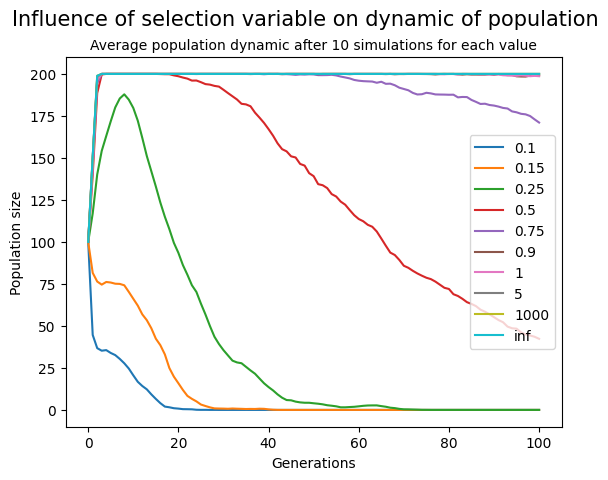

In [ ]:
plotting_N_for_multiple_populations(recordings, "selection variable")

# Analiza wpływu wariancji zmian środowiskowych

In [ ]:
N = 100 #ile osobników
l = 2 # ile cech ma genom
p = 1 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = 0.5
rates = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.15, 0.25]
catastrophic_scenario = False
n_of_generations = 100  

In [ ]:
recordings_r = {rate:[] for rate in rates}
for rate in rates:
  for i in range(0,100):
    pop  = Population(N, l, p, var, optimal_genotype, selection_variable, rate, catastrophic_scenario)
    r = pop.simulation(n_of_generations)
    recordings_r[rate].append(r)

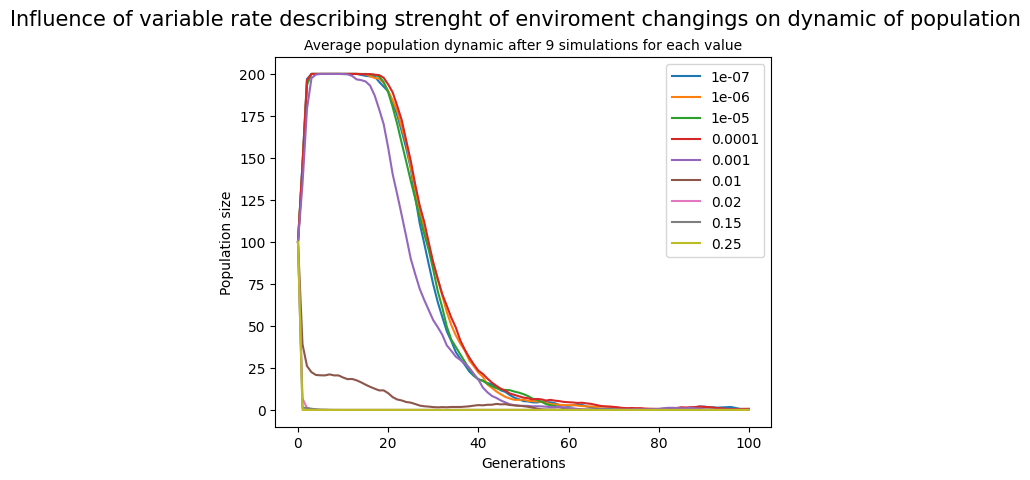

In [ ]:
plotting_N_for_multiple_populations(recordings_r, "variable rate describing strenght of enviroment changings")


# avarage

In [ ]:
N = 100 #ile osobników
l = 2 # ile cech ma genom
p = 0.075 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = 0.5
rates =  0.00001
catastrophic_scenario = False
n_of_generations = 200
recordings_list = []
for i in range(0,100):
  pop = Population(N, l, p, var, optimal_genotype, selection_variable, rates, catastrophic_scenario)
  recordings_list.append(pop.simulation(n_of_generations).n_of_inds)

In [ ]:
def plotting_avarage_N(list_of_histories):
  avg = np.average(np.array(list_of_histories), axis=0)
  plt.plot(avg, color = "r", label = "Average")
  plt.axline((0,0),(1,0), color = 'b')
  std = np.std(np.array(list_of_histories), axis=0)
  plt.fill_between(range(0,len(list_of_histories[0])), avg-std, avg+std, facecolor='blue', alpha=0.5)
  plt.legend()
  plt.title(f"Avarage dynamic of populations - {len(list_of_histories)} iterations")
  plt.show()

In [ ]:
plotting_avarage_N(recordings_list)

# Catastrophe

In [ ]:
N = 100 #ile osobników
l = 4 # ile cech ma genom
p = 0.075 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = 0.5
rates =  0.0001
catastrophic_scenario = True
n_of_generations = 200  
pop_cat = Population(N, l, p, var, optimal_genotype, selection_variable, rates, catastrophic_scenario)
cat_record, w_cat_record = pop_cat.simulation(n_of_generations)

In [ ]:
N = 100 #ile osobników
l = 2 # ile cech ma genom
p = 0.075 # szansa na mutację
var = 0.01 #wariancja rozkładu określająca siłę mutacji
optimal_genotype = [0 for _ in range(0,l)]
selection_variable = 0.5
rates =  [0.00001, 0.0001, 0.001, 0.01]
catastrophic_scenario = True
n_of_generations = 200
dict_of_recordings = {rate:[] for rate in rates}
for i in range(0,50):
  for rate in rates:
    recordings = []
    pop_cat = Population(N, l, p, var, optimal_genotype, selection_variable, rate, catastrophic_scenario)
    cat_record, w_cat_record = pop_cat.simulation(n_of_generations)
    dict_of_recordings[rate].append((cat_record, w_cat_record))

In [ ]:
def plotting_catastrophe(recordings_dict):
  fig, ax = plt.subplots(2, 2)
  recordings_dict_items = list(recordings_dict.items())

  i = 0
  def subplotting(rate, recordings, param):
    recordings_cat = [recordings[i][0].n_of_inds for i in range(0, len(recordings))]
    recordings_w_cat = [recordings[i][1].n_of_inds for i in range(0, len(recordings))]
    avg_cat = np.average(np.array(recordings_cat), axis=0)
    
    ax[param].plot(avg_cat, color = "purple")
    ax[param].axhline(0,  color = 'black')
    ax[param].axvline(recordings[0][0].time_of_catastrophe, color="r")
    std_cat = np.std(np.array(recordings_cat), axis=0)
    ax[param].fill_between(range(0,len(recordings[0][0].n_of_inds)), avg_cat-std_cat, avg_cat+std_cat, facecolor='purple', alpha=0.35)
    avg_w_cat = np.average(np.array(recordings_w_cat), axis=0)
    ax[param].plot(avg_w_cat, color = "green")
    std_w_cat = np.std(np.array(recordings_w_cat), axis=0)
    ax[param].fill_between(range(0,len(recordings[0][1].n_of_inds)), avg_w_cat-std_w_cat, avg_w_cat+std_w_cat, facecolor='green', alpha=0.35)
    ax[param].set_title(f"r^2 = {rate}")
  for k in [0.1]:
    for j in [0,1]:
      rate, recording = recordings_dict_items[i]
      i += 1
      subplotting(rate, recording, (k,j))
  for ax_ in ax.flat:
      ax_.set(xlabel='Generations', ylabel='Population size')
  for ax_ in ax.flat:
      ax_.label_outer()

  fig.suptitle('Catastrophe and its influence on population size', fontsize=15)
  fig.title(f"Avarage dynamic of populations - {len(recordings)} iterations", fontsize = 10)
  plt.show()
  '''for cat_record, w_cat_record in recordings:
    plt.plot(cat_record.n_of_inds, label = "After catastrophe")
    plt.plot(w_cat_record.n_of_inds, label = "Without catastrophe")
    plt.axline((cat_record.time_of_catastrophe, 0),(cat_record.time_of_catastrophe, 100), color="r")
    plt.legend()
    plt.xlabel('Generations')
    plt.ylabel('Population size')
    plt.title('Catastrophe and its influence on population size')
    plt.show()'''

In [ ]:
def plotting_gene_changes_cat(recordings):
  recordings_cat = [recordings[i][0].all_genomes for i in range(0, len(recordings))]
  recordings_w_cat = [recordings[i][1].all_genomes for i in range(0, len(recordings))]
  def subplot(recordings, x, col, a):
    gene_x = [record.genes_x(x-1) for record in recordings]
    mean_gene = mean(g)
    mean_gene = [mean(g) for g in (record.genes_x(x-1)) for record in recordings]  # lista średnich wartości genów w iteracjach
    n = [i for i in range(len(mean_gene))]  # liczba interacji
    gene_std = [np.std(g, ddof=1) for g in (record.genes_x(x-1))][0:len(mean_gene)]  # lista std dla każdej iteracji
    a[x - 1].plot(n, mean_gene, color=col, label='mean')
    a[x - 1].fill_between(n, np.array(mean_gene) + np.array(gene_std), np.array(mean_gene) - np.array(gene_std), facecolor=col, alpha=0.5,
                          label='standard deviation')
    a[x - 1].plot(n, record.gene_x_optimum(x)[:len(n)], color='red', label='optimal gene value')
    a[x - 1].set_title('Gen %d' % x, fontsize='small', loc='left')
    a[x - 1].legend(loc='upper right', prop={'size': 6})

    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Changes in values of genes')
    subplot(1, "green", axs)
    subplot(2, "blue", axs)
    #subplot(3, "purple", axs)
    # ! jakaś ładniejsza legenda może
    fig.supxlabel('Interation')
    fig.supylabel('Average Gen Value')
    plt.show()
  

In [ ]:
plotting_catastrophe(dict_of_recordings)


In [ ]:
fig, axs = plt.subplots(2, 2)
j = 1
k = 0
param = (k,j)
axs[(k,j)].plot([2,3], [5,6])
axs[param].axvline(3, color="r")